# LSTM

## Get preprocessed data

In [1]:
import boto3
from boto3 import session
import os

key_id = os.environ.get("AWS_ACCESS_KEY_ID")
secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
bucket_name = os.environ.get("AWS_S3_BUCKET")
s3_endpoint = os.environ.get("AWS_S3_ENDPOINT")

s3_client = boto3.client("s3", aws_access_key_id=key_id, aws_secret_access_key=secret_key, endpoint_url=s3_endpoint)

In [2]:
s3_client.download_file(bucket_name, "preprocessed.csv", 'preprocessed.csv')

In [3]:
import pandas as pd

df=pd.read_csv("preprocessed.csv", encoding="latin_1")

## Train LSTM

In [5]:
import numpy as np

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2025-03-20 10:03:08.686503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 10:03:08.701661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 10:03:08.706392: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 10:03:08.718567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 10:03:09.619726: W tensorflow/compiler/tf2

In [7]:
from sklearn.model_selection import train_test_split

X_data, y_data = np.array(df['text']), np.array(df['target'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')



Data Split done.


In [8]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))


input_length = 60
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)



X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)


embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)



Vocabulary Length: 44031
Tokenizer vocab length: 60000
X_train.shape: (1499732, 60)
X_test.shape : (78934, 60)
Embedding Matrix Shape: (60000, 100)


In [9]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

training_model = getModel()
training_model.summary()


/opt/app-root/lib64/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1742465044.671256    1432 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742465044.697843    1432 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742465044.704623    1432 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torval

Model: "Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history = training_model.fit(
    X_train, y_train,
    batch_size=4096,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)



Epoch 1/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 61s 177ms/step - accuracy: 0.7966 - loss: 0.4303 - val_accuracy: 0.8002 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 2/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 58s 175ms/step - accuracy: 0.7977 - loss: 0.4299 - val_accuracy: 0.8012 - val_loss: 0.4248 - learning_rate: 0.0010
Epoch 3/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 58s 174ms/step - accuracy: 0.7976 - loss: 0.4296 - val_accuracy: 0.8011 - val_loss: 0.4260 - learning_rate: 0.0010
Epoch 4/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 58s 175ms/step - accuracy: 0.7995 - loss: 0.4268 - val_accuracy: 0.8014 - val_loss: 0.4248 - learning_rate: 0.0010
Epoch 5/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 58s 175ms/step - accuracy: 0.7998 - loss: 0.4259 - val_accuracy: 0.8024 - val_loss: 0.4252 - learning_rate: 0.0010
Epoch 6/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 58s 175ms/step - accuracy: 0.8006 - loss: 0.4244 - val_accuracy: 0.8028 - val_loss: 0.4239 - learning_rate: 0.0010
Epoch 7/12
330/330 ━━━━━━━━━━━━━━━━━━━━ 58s 175ms/step - accuracy: 0.8

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

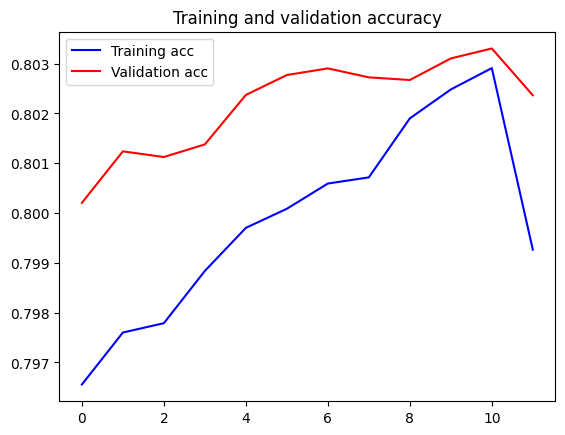

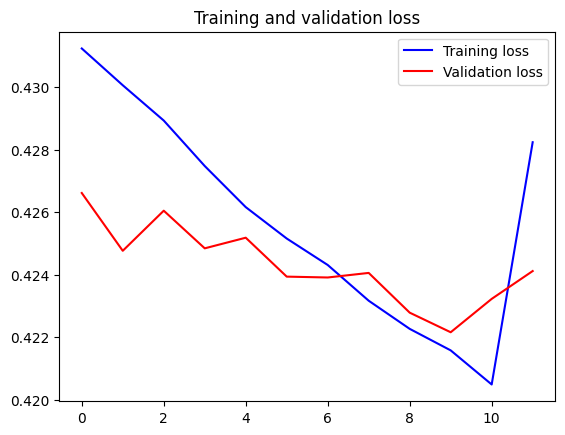

In [25]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

2467/2467 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


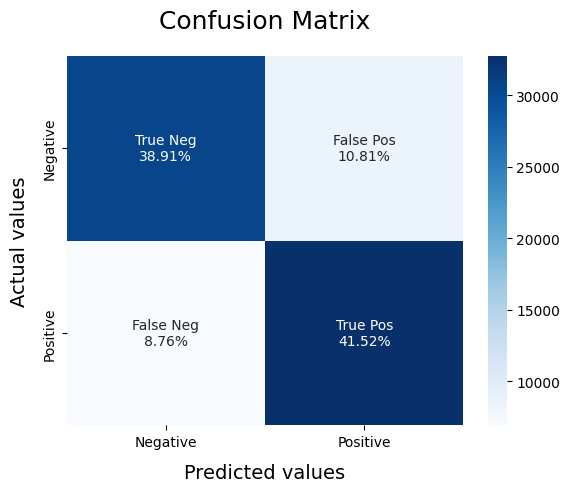

In [27]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [30]:


# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.82      0.78      0.80     39244
           1       0.79      0.83      0.81     39690

    accuracy                           0.80     78934
   macro avg       0.80      0.80      0.80     78934
weighted avg       0.80      0.80      0.80     78934



In [36]:
training_model.save('lstm.keras')

In [31]:
training_model.export('lstm')

INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


Saved artifact at 'lstm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140632945426896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140629860765520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140629860771856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140629860764944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140629860774736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140629860764752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140629860774160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140629860776080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140629860777808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140629860766288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140629860777040: TensorSpec(shape=(

In [44]:
from datetime import datetime
run_id = str(datetime.now().strftime("%d-%m-%Y_%H:%M:%S"))

In [45]:
import boto3
import os

def upload_directory_to_s3(local_directory, bucket, s3_prefix='', endpoint_url=None, aws_access_key_id=None, aws_secret_access_key=None):
    """
    Uploads a local directory and its subdirectories to an S3 bucket.

    :param local_directory: The local directory to upload.
    :param bucket: The name of the S3 bucket.
    :param s3_prefix: The prefix to add to the S3 keys.
    :param endpoint_url: The custom endpoint URL for S3.
    :param aws_access_key_id: Your AWS access key ID.
    :param aws_secret_access_key: Your AWS secret access key.
    """
    s3_client = boto3.client(
        's3',
        endpoint_url=endpoint_url,
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key
    )
    
    for root, dirs, files in os.walk(local_directory):
        # Skip directories named ".git"
        dirs[:] = [d for d in dirs if d != '.git']
        
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(s3_prefix, relative_path).replace("\\", "/")
            
            print(f'Uploading {local_path} to s3://{bucket}/{s3_path}')
            s3_client.upload_file(local_path, bucket, s3_path)

# Set your local directory, bucket name, and other parameters here
local_directory = 'lstm'
prefix = 'sentiment-analysis/lstm/'+run_id+'/1/'
models_bucket = 'models'

upload_directory_to_s3(local_directory, models_bucket, prefix,s3_endpoint, key_id, secret_key)

Uploading lstm/fingerprint.pb to s3://models/sentiment-analysis/lstm/20-03-2025_10:41:00/1/fingerprint.pb
Uploading lstm/saved_model.pb to s3://models/sentiment-analysis/lstm/20-03-2025_10:41:00/1/saved_model.pb
Uploading lstm/variables/variables.data-00000-of-00001 to s3://models/sentiment-analysis/lstm/20-03-2025_10:41:00/1/variables/variables.data-00000-of-00001
Uploading lstm/variables/variables.index to s3://models/sentiment-analysis/lstm/20-03-2025_10:41:00/1/variables/variables.index


In [46]:
object_path = 'sentiment-analysis/lstm/' + run_id + '/lstm.keras'
s3_client.upload_file('lstm.keras', models_bucket, object_path)